RollingBall:玩家（或智能体）通过施加力控制小球，从网格起点（[0.2*宽, 0.2*高]）移动到目标点（[0.8*宽, 0.8*高]）。

核心特点：
- **环境**：10x10 网格（可调），小球受力、摩擦（系数 0.0046）、边界碰撞（恢复系数 0.8）影响，速度上限 5.0。
- **动作**：连续力（[-0.1, 0.1]），可离散化为 5x5 动作（[-0.8, -0.4, 0, 0.4, 0.8]）并展平为 25 个动作。
- **奖励**：每步 -2.0，撞墙 -10.0，到达目标 +300.0。
- **渲染**：Pygame 显示蓝色小球、紫色目标，可选灰色轨迹，300x300 像素窗口。

In [11]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from gym.utils.env_checker import check_env
from RL_DQN_Class import DQN,ReplayBuffer,DoubleDQN
from gym.wrappers import TimeLimit
from two_dimensional_rolling_motion import RollingBall, DiscreteActionWrapper, FlattenActionSpaceWrapper

In [12]:
if __name__ == "__main__":
    def moving_average(a, window_size):
        ''' 生成序列 a 的滑动平均序列 '''
        # 计算滑动平均，平滑序列（如回合回报），便于绘图时观察趋势
        # 参数：a（输入序列，如回报列表），window_size（窗口大小，后续设为 29）
        cumulative_sum = np.cumsum(np.insert(a, 0, 0))
        # 计算累积和，插入 0 便于差分计算窗口平均值
        middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
        # 中间部分：通过累积和差分计算窗口平均值
        r = np.arange(1, window_size-1, 2)
        # 生成奇数序列 [1, 3, 5, ...]，用于处理开头和结尾的小窗口
        begin = np.cumsum(a[:window_size-1])[::2] / r
        # 开头部分：计算前 window_size-1 个元素的小窗口平均值
        end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
        # 结尾部分：计算最后 window_size-1 个元素的反向小窗口平均值，翻转对齐
        return np.concatenate((begin, middle, end))
        # 拼接开头、中间、结尾，返回等长滑动平均序列

    def set_seed(env, seed=42):
        ''' 设置随机种子 '''
        # 设置随机种子，确保环境和算法行为一致，实验可重复
        env.action_space.seed(seed)
        # 为动作空间设置种子，确保动作采样一致
        env.reset(seed=seed)
        # 重置环境，应用种子，确保初始状态一致
        random.seed(seed)
        # 设置 Python random 模块种子，用于随机动作选择
        np.random.seed(seed)
        # 设置 NumPy 随机种子，用于数组操作和采样
        torch.manual_seed(seed)
        # 设置 PyTorch 种子，确保神经网络初始化和训练一致

    state_dim = 4                               # 环境观测维度
    # 状态维度为 4，对应 RollingBall 环境的观测 [x_position, y_position, x_velocity, y_velocity]
    action_dim = 1                              # 环境动作维度
    action_bins = 10                            # 动作离散 bins 数量
    action_range = action_bins * action_bins    # 环境动作空间大小
    hidden_dim = 32                             # 神经网络隐藏层大小
    # 学习率不建议太大，很难收敛
    lr = 0.001                                   # 学习率
    num_episodes = 1000                         # 总训练回合数
    gamma = 0.99                                # 折扣因子
    epsilon_start = 0.2                       # 初始探索率
    epsilon_end = 0.01                        # 最终探索率
    tau = 0.001                        # 目标网络更新参数
    buffer_size = 10000                         # 回放缓冲区容量
    minimal_size = 5000                         # 训练前最小缓冲区大小
    batch_size = 128                            # 批量大小
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # 优先使用 GPU（CUDA），否则使用 CPU，加速神经网络计算

    # 构建环境
    env = RollingBall(width=8, height=8, show_epi=True)
    # 创建 5x5 的 RollingBall 环境，显示小球轨迹
    # 参考 GridWorld.py：
    # - 初始位置：(1, 1)（0.2 * 5）
    # - 目标位置：(4, 4)（0.8 * 5）
    # - 奖励：每步 -2.0，撞墙 -10.0，目标 +300.0
    # - 动作空间：Box([-0.1, 0.1], shape=(2,))，x 和 y 方向的力
    # - 观测空间：Box([0, 0, -5, -5], [5, 5, 5, 5])，[x, y, vx, vy]
    env = FlattenActionSpaceWrapper(DiscreteActionWrapper(env, bins=10))
    # 包装动作空间：
    # 1. DiscreteActionWrapper（参考 Hashposotion.py）：
    #    - 将连续动作离散化为 MultiDiscrete([10, 10])
    #    - 每个维度 10 个 bins，映射到 [-1, 1]，步长 0.2
    # 2. FlattenActionSpaceWrapper：
    #    - 展平为 Discrete(100)，动作索引 0-99
    env = TimeLimit(env, 100)
    # 限制每回合最大 100 步，超限返回 truncated=True
    check_env(env.unwrapped)
    # 检查原始 RollingBall 环境是否符合 Gym 规范
    set_seed(env, seed=42)
    # 设置环境随机种子，确保一致性

    # 构建代理和回放缓冲区
    replay_buffer = ReplayBuffer(buffer_size)
    # 创建回放缓冲区，容量 10000，存储经验 (state, action, reward, next_state, done)
    agent = DQN(state_dim, hidden_dim, action_dim, action_range, lr, gamma, epsilon_start, tau, device)
    # 创建 DQN 代理（假设 DQN 类已定义）
    # 配置：4 维状态输入，100 个动作输出，32 单元隐藏层，学习率 0.001，折扣因子 0.99
    # 功能：epsilon-greedy 动作选择，Q 网络更新，目标网络定期同步

    # 随机动作填充回放缓冲区
    state, _ = env.reset()
    # 重置环境，获取初始状态
    while replay_buffer.size() <= minimal_size:
        action = env.action_space.sample()
        # 随机选择动作（0-99）
        next_state, reward, terminated, truncated, _ = env.step(action)
        # 执行动作，获取下一状态、奖励、终止标志等
        replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
        # 存储经验，done 表示回合是否结束
        state = next_state
        # 更新状态
        if terminated or truncated:
            env.render()
            # 回合结束时渲染，显示小球轨迹
            state, _ = env.reset()
            # 重置环境
        #print(replay_buffer.size())
        # （注释掉）可打印缓冲区大小，监控填充进度

    # 开始训练
    return_list = []
    # 存储每回合总回报
    max_q_value_list = []
    # 存储平滑的最大 Q 值
    max_q_value = 0
    # 用于平滑 Q 值的初始值
    for i in range(20):
        # 分 20 次迭代，每迭代 50 回合，共 1000 回合
        with tqdm(total=int(num_episodes / 20), desc='Iteration %d' % i) as pbar:
            # 使用 tqdm 显示进度条
            for i_episode in range(int(num_episodes / 20)):
                # 每迭代 50 回合
                episode_return = 0
                # 初始化回合回报
                state, _ = env.reset()
                # 重置环境
                while True:
                    # 计算并平滑最大 Q 值
                    max_q_value = agent.max_q_value_of_given_state(state) * 0.005 + max_q_value * 0.995
                    # 使用指数平滑，权重 0.005（新值）和 0.995（旧值）
                    max_q_value_list.append(max_q_value)
                    # 记录 Q 值

                    # 选择并执行动作
                    action = agent.take_action(state)
                    # 使用 epsilon-greedy 策略选择动作
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    # 执行动作，获取结果

                    # 更新回放缓冲区
                    replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
                    # 存储新经验

                    # 训练 Q 网络
                    assert replay_buffer.size() > minimal_size
                    # 确保缓冲区足够大
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    # 采样 128 条经验
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    # 组织批量数据
                    agent.update(transition_dict)
                    # 更新 Q 网络，计算 Q 学习损失并优化

                    state = next_state
                    # 更新状态
                    episode_return += reward
                    # 累加回报

                    if terminated or truncated:
                        env.render()
                        # 回合结束时渲染
                        if terminated:
                            print(f"Episode {num_episodes / 20 * i + i_episode + 1}: Goal reached!")   
                        break
                    #env.render()
                    # （注释掉）可每步渲染，但会减慢训练

                return_list.append(episode_return)
                # 记录回合回报
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                    # 每 10 回合更新进度条，显示回合数和最近 10 次平均回报
                pbar.update(1)
                # 更新进度条

        #env.render()
        # （注释掉）迭代结束时可渲染
        agent.epsilon += (epsilon_end - epsilon_start) / 10
        # 调整 epsilon，注意：应为衰减，可能需改为 agent.epsilon = epsilon_start + (epsilon_end - epsilon_start) * i / 19
    env.close()
    # 显示训练结果
    mv_return_list = moving_average(return_list, 29)
    # 计算 29 步滑动平均回报
    episodes_list = list(range(len(return_list)))
    # 生成回合索引
    plt.figure(figsize=(12,8))
    # 创建 12x8 英寸画布
    plt.plot(episodes_list, return_list, label='raw', alpha=0.5)
    # 绘制原始回报，半透明
    plt.plot(episodes_list, mv_return_list, label='moving ave')
    # 绘制平滑回报
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题，包含代理名称（如 DQN）
    plt.legend()
    # 显示图例
    plt.savefig(f'./result/{agent._get_name()}.png')
    # 保存回报曲线
    plt.show()
    # 显示图像
    # 显示最大 Q 值
    frames_list = list(range(len(max_q_value_list)))
    # 生成帧索引
    plt.plot(frames_list, max_q_value_list)
    # 绘制平滑 Q 值曲线
    plt.axhline(max(max_q_value_list), c='orange', ls='--')
    # 标记最大 Q 值
    plt.xlabel('Frames')
    plt.ylabel('Max Q_value')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题
    plt.savefig(f'./result/{agent._get_name()}_MaxQ.png')
    # 保存 Q 值曲线
    plt.show()
    # 显示图像

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]


UnboundLocalError: local variable 'reward' referenced before assignment

#### Double DQN：


Episode 469.0: Goal reached!
Episode 470.0: Goal reached!


Iteration 9:  44%|████▍     | 22/50 [00:03<00:04,  6.64it/s, episode=920, return=537.120]

Episode 471.0: Goal reached!
Episode 472.0: Goal reached!


Iteration 9:  48%|████▊     | 24/50 [00:03<00:03,  6.63it/s, episode=920, return=537.120]

Episode 473.0: Goal reached!
Episode 474.0: Goal reached!


Iteration 9:  50%|█████     | 25/50 [00:04<00:03,  6.64it/s, episode=920, return=537.120]

Episode 475.0: Goal reached!


Iteration 9:  56%|█████▌    | 28/50 [00:04<00:03,  5.53it/s, episode=920, return=537.120]

Episode 477.0: Goal reached!
Episode 478.0: Goal reached!


Iteration 9:  60%|██████    | 30/50 [00:04<00:03,  6.14it/s, episode=930, return=582.746]

Episode 479.0: Goal reached!
Episode 480.0: Goal reached!


Iteration 9:  64%|██████▍   | 32/50 [00:05<00:02,  6.06it/s, episode=930, return=582.746]

Episode 481.0: Goal reached!
Episode 482.0: Goal reached!


Iteration 9:  68%|██████▊   | 34/50 [00:05<00:02,  6.35it/s, episode=930, return=582.746]

Episode 483.0: Goal reached!
Episode 484.0: Goal reached!


Iteration 9:  70%|███████   | 35/50 [00:05<00:02,  6.21it/s, episode=930, return=582.746]

Episode 485.0: Goal reached!
Episode 486.0: Goal reached!


Iteration 9:  76%|███████▌  | 38/50 [00:06<00:02,  5.51it/s, episode=930, return=582.746]

Episode 487.0: Goal reached!
Episode 488.0: Goal reached!


Iteration 9:  80%|████████  | 40/50 [00:06<00:01,  5.75it/s, episode=940, return=527.474]

Episode 489.0: Goal reached!
Episode 490.0: Goal reached!


Iteration 9:  84%|████████▍ | 42/50 [00:07<00:01,  5.69it/s, episode=940, return=527.474]

Episode 491.0: Goal reached!
Episode 492.0: Goal reached!


Iteration 9:  88%|████████▊ | 44/50 [00:07<00:01,  5.97it/s, episode=940, return=527.474]

Episode 493.0: Goal reached!
Episode 494.0: Goal reached!


Iteration 9:  92%|█████████▏| 46/50 [00:07<00:00,  6.13it/s, episode=940, return=527.474]

Episode 495.0: Goal reached!
Episode 496.0: Goal reached!


Iteration 9:  96%|█████████▌| 48/50 [00:08<00:00,  6.08it/s, episode=940, return=527.474]

Episode 497.0: Goal reached!
Episode 498.0: Goal reached!


Iteration 9: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s, episode=950, return=529.811]


Episode 499.0: Goal reached!
Episode 500.0: Goal reached!


Iteration 10:   4%|▍         | 2/50 [00:00<00:07,  6.33it/s]

Episode 501.0: Goal reached!
Episode 502.0: Goal reached!


Iteration 10:   8%|▊         | 4/50 [00:00<00:07,  5.99it/s]

Episode 503.0: Goal reached!
Episode 504.0: Goal reached!


Iteration 10:  12%|█▏        | 6/50 [00:00<00:07,  6.22it/s]

Episode 505.0: Goal reached!
Episode 506.0: Goal reached!


Iteration 10:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

Episode 507.0: Goal reached!
Episode 508.0: Goal reached!


Iteration 10:  20%|██        | 10/50 [00:01<00:06,  5.94it/s, episode=1010, return=543.302]

Episode 509.0: Goal reached!
Episode 510.0: Goal reached!


Iteration 10:  24%|██▍       | 12/50 [00:01<00:06,  6.10it/s, episode=1010, return=543.302]

Episode 511.0: Goal reached!
Episode 512.0: Goal reached!


Iteration 10:  28%|██▊       | 14/50 [00:02<00:05,  6.50it/s, episode=1010, return=543.302]

Episode 513.0: Goal reached!
Episode 514.0: Goal reached!


Iteration 10:  32%|███▏      | 16/50 [00:02<00:05,  6.78it/s, episode=1010, return=543.302]

Episode 515.0: Goal reached!
Episode 516.0: Goal reached!


Iteration 10:  36%|███▌      | 18/50 [00:02<00:04,  6.83it/s, episode=1010, return=543.302]

Episode 517.0: Goal reached!
Episode 518.0: Goal reached!


Iteration 10:  40%|████      | 20/50 [00:03<00:04,  6.71it/s, episode=1020, return=540.853]

Episode 519.0: Goal reached!
Episode 520.0: Goal reached!


Iteration 10:  44%|████▍     | 22/50 [00:03<00:04,  6.97it/s, episode=1020, return=540.853]

Episode 521.0: Goal reached!
Episode 522.0: Goal reached!


Iteration 10:  48%|████▊     | 24/50 [00:03<00:03,  6.99it/s, episode=1020, return=540.853]

Episode 523.0: Goal reached!
Episode 524.0: Goal reached!


Iteration 10:  50%|█████     | 25/50 [00:03<00:03,  6.78it/s, episode=1020, return=540.853]

Episode 525.0: Goal reached!
Episode 526.0: Goal reached!


Iteration 10:  56%|█████▌    | 28/50 [00:04<00:03,  6.21it/s, episode=1020, return=540.853]

Episode 527.0: Goal reached!
Episode 528.0: Goal reached!


Iteration 10:  60%|██████    | 30/50 [00:04<00:03,  6.61it/s, episode=1030, return=544.895]

Episode 529.0: Goal reached!
Episode 530.0: Goal reached!


Iteration 10:  64%|██████▍   | 32/50 [00:04<00:02,  6.68it/s, episode=1030, return=544.895]

Episode 531.0: Goal reached!
Episode 532.0: Goal reached!


Iteration 10:  68%|██████▊   | 34/50 [00:05<00:02,  6.77it/s, episode=1030, return=544.895]

Episode 533.0: Goal reached!
Episode 534.0: Goal reached!


Iteration 10:  72%|███████▏  | 36/50 [00:05<00:02,  6.96it/s, episode=1030, return=544.895]

Episode 535.0: Goal reached!
Episode 536.0: Goal reached!


Iteration 10:  76%|███████▌  | 38/50 [00:05<00:01,  6.81it/s, episode=1030, return=544.895]

Episode 537.0: Goal reached!
Episode 538.0: Goal reached!


Iteration 10:  80%|████████  | 40/50 [00:06<00:01,  6.55it/s, episode=1040, return=543.902]

Episode 539.0: Goal reached!
Episode 540.0: Goal reached!


Iteration 10:  84%|████████▍ | 42/50 [00:06<00:01,  6.82it/s, episode=1040, return=543.902]

Episode 541.0: Goal reached!
Episode 542.0: Goal reached!


Iteration 10:  88%|████████▊ | 44/50 [00:06<00:00,  6.80it/s, episode=1040, return=543.902]

Episode 543.0: Goal reached!
Episode 544.0: Goal reached!


Iteration 10:  92%|█████████▏| 46/50 [00:07<00:00,  6.39it/s, episode=1040, return=543.902]

Episode 545.0: Goal reached!
Episode 546.0: Goal reached!


Iteration 10:  96%|█████████▌| 48/50 [00:07<00:00,  6.63it/s, episode=1040, return=543.902]

Episode 547.0: Goal reached!
Episode 548.0: Goal reached!


Iteration 10: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s, episode=1050, return=538.189]


Episode 549.0: Goal reached!
Episode 550.0: Goal reached!


Iteration 11:   4%|▍         | 2/50 [00:00<00:07,  6.70it/s]

Episode 551.0: Goal reached!
Episode 552.0: Goal reached!


Iteration 11:   8%|▊         | 4/50 [00:00<00:06,  6.81it/s]

Episode 553.0: Goal reached!
Episode 554.0: Goal reached!


Iteration 11:  12%|█▏        | 6/50 [00:00<00:06,  6.54it/s]

Episode 555.0: Goal reached!
Episode 556.0: Goal reached!


Iteration 11:  16%|█▌        | 8/50 [00:01<00:06,  6.84it/s]

Episode 557.0: Goal reached!
Episode 558.0: Goal reached!


Iteration 11:  20%|██        | 10/50 [00:01<00:05,  7.12it/s, episode=1110, return=536.355]

Episode 559.0: Goal reached!
Episode 560.0: Goal reached!


Iteration 11:  24%|██▍       | 12/50 [00:01<00:05,  6.83it/s, episode=1110, return=536.355]

Episode 561.0: Goal reached!
Episode 562.0: Goal reached!


Iteration 11:  28%|██▊       | 14/50 [00:02<00:05,  6.72it/s, episode=1110, return=536.355]

Episode 563.0: Goal reached!
Episode 564.0: Goal reached!


Iteration 11:  32%|███▏      | 16/50 [00:02<00:05,  6.68it/s, episode=1110, return=536.355]

Episode 565.0: Goal reached!
Episode 566.0: Goal reached!


Iteration 11:  36%|███▌      | 18/50 [00:02<00:04,  6.61it/s, episode=1110, return=536.355]

Episode 567.0: Goal reached!
Episode 568.0: Goal reached!


Iteration 11:  40%|████      | 20/50 [00:02<00:04,  6.81it/s, episode=1120, return=541.435]

Episode 569.0: Goal reached!
Episode 570.0: Goal reached!


Iteration 11:  46%|████▌     | 23/50 [00:03<00:04,  5.78it/s, episode=1120, return=541.435]

Episode 572.0: Goal reached!
Episode 573.0: Goal reached!


Iteration 11:  50%|█████     | 25/50 [00:03<00:04,  6.19it/s, episode=1120, return=541.435]

Episode 574.0: Goal reached!
Episode 575.0: Goal reached!


Iteration 11:  54%|█████▍    | 27/50 [00:04<00:03,  6.75it/s, episode=1120, return=541.435]

Episode 576.0: Goal reached!
Episode 577.0: Goal reached!


Iteration 11:  58%|█████▊    | 29/50 [00:04<00:02,  7.05it/s, episode=1120, return=541.435]

Episode 578.0: Goal reached!
Episode 579.0: Goal reached!


Iteration 11:  62%|██████▏   | 31/50 [00:04<00:02,  6.60it/s, episode=1130, return=526.591]

Episode 580.0: Goal reached!
Episode 581.0: Goal reached!


Iteration 11:  66%|██████▌   | 33/50 [00:05<00:02,  6.54it/s, episode=1130, return=526.591]

Episode 582.0: Goal reached!
Episode 583.0: Goal reached!


Iteration 11:  68%|██████▊   | 34/50 [00:05<00:02,  5.82it/s, episode=1130, return=526.591]

Episode 584.0: Goal reached!


Iteration 11:  72%|███████▏  | 36/50 [00:05<00:02,  5.73it/s, episode=1130, return=526.591]

Episode 585.0: Goal reached!
Episode 586.0: Goal reached!


Iteration 11:  76%|███████▌  | 38/50 [00:05<00:01,  6.06it/s, episode=1130, return=526.591]

Episode 587.0: Goal reached!
Episode 588.0: Goal reached!


Iteration 11:  80%|████████  | 40/50 [00:06<00:01,  6.57it/s, episode=1140, return=540.227]

Episode 589.0: Goal reached!
Episode 590.0: Goal reached!


Iteration 11:  84%|████████▍ | 42/50 [00:06<00:01,  6.88it/s, episode=1140, return=540.227]

Episode 591.0: Goal reached!
Episode 592.0: Goal reached!


Iteration 11:  88%|████████▊ | 44/50 [00:06<00:00,  7.08it/s, episode=1140, return=540.227]

Episode 593.0: Goal reached!
Episode 594.0: Goal reached!


Iteration 11:  92%|█████████▏| 46/50 [00:07<00:00,  6.68it/s, episode=1140, return=540.227]

Episode 595.0: Goal reached!
Episode 596.0: Goal reached!


Iteration 11:  96%|█████████▌| 48/50 [00:07<00:00,  6.83it/s, episode=1140, return=540.227]

Episode 597.0: Goal reached!
Episode 598.0: Goal reached!


Iteration 11: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s, episode=1150, return=540.019]


Episode 599.0: Goal reached!
Episode 600.0: Goal reached!


Iteration 12:   4%|▍         | 2/50 [00:00<00:07,  6.46it/s]

Episode 601.0: Goal reached!
Episode 602.0: Goal reached!


Iteration 12:   8%|▊         | 4/50 [00:00<00:06,  6.72it/s]

Episode 603.0: Goal reached!
Episode 604.0: Goal reached!


Iteration 12:  12%|█▏        | 6/50 [00:00<00:06,  6.75it/s]

Episode 605.0: Goal reached!
Episode 606.0: Goal reached!


Iteration 12:  16%|█▌        | 8/50 [00:01<00:06,  6.75it/s]

Episode 607.0: Goal reached!
Episode 608.0: Goal reached!


Iteration 12:  20%|██        | 10/50 [00:01<00:05,  7.04it/s, episode=1210, return=541.773]

Episode 609.0: Goal reached!
Episode 610.0: Goal reached!


Iteration 12:  24%|██▍       | 12/50 [00:01<00:05,  6.92it/s, episode=1210, return=541.773]

Episode 611.0: Goal reached!
Episode 612.0: Goal reached!


Iteration 12:  28%|██▊       | 14/50 [00:02<00:05,  6.90it/s, episode=1210, return=541.773]

Episode 613.0: Goal reached!
Episode 614.0: Goal reached!


Iteration 12:  32%|███▏      | 16/50 [00:02<00:04,  6.99it/s, episode=1210, return=541.773]

Episode 615.0: Goal reached!
Episode 616.0: Goal reached!


Iteration 12:  36%|███▌      | 18/50 [00:02<00:04,  6.76it/s, episode=1210, return=541.773]

Episode 617.0: Goal reached!
Episode 618.0: Goal reached!


Iteration 12:  40%|████      | 20/50 [00:02<00:04,  6.85it/s, episode=1220, return=541.416]

Episode 619.0: Goal reached!
Episode 620.0: Goal reached!


Iteration 12:  44%|████▍     | 22/50 [00:03<00:04,  6.88it/s, episode=1220, return=541.416]

Episode 621.0: Goal reached!
Episode 622.0: Goal reached!


Iteration 12:  48%|████▊     | 24/50 [00:03<00:03,  7.03it/s, episode=1220, return=541.416]

Episode 623.0: Goal reached!
Episode 624.0: Goal reached!


Iteration 12:  52%|█████▏    | 26/50 [00:03<00:03,  6.80it/s, episode=1220, return=541.416]

Episode 625.0: Goal reached!
Episode 626.0: Goal reached!


Iteration 12:  56%|█████▌    | 28/50 [00:04<00:03,  6.86it/s, episode=1220, return=541.416]

Episode 627.0: Goal reached!
Episode 628.0: Goal reached!


Iteration 12:  60%|██████    | 30/50 [00:04<00:02,  7.00it/s, episode=1230, return=542.165]

Episode 629.0: Goal reached!
Episode 630.0: Goal reached!


Iteration 12:  64%|██████▍   | 32/50 [00:04<00:02,  6.78it/s, episode=1230, return=542.165]

Episode 631.0: Goal reached!
Episode 632.0: Goal reached!


Iteration 12:  68%|██████▊   | 34/50 [00:04<00:02,  6.92it/s, episode=1230, return=542.165]

Episode 633.0: Goal reached!
Episode 634.0: Goal reached!


Iteration 12:  72%|███████▏  | 36/50 [00:05<00:02,  6.29it/s, episode=1230, return=542.165]

Episode 635.0: Goal reached!
Episode 636.0: Goal reached!


Iteration 12:  76%|███████▌  | 38/50 [00:05<00:01,  6.06it/s, episode=1230, return=542.165]

Episode 637.0: Goal reached!
Episode 638.0: Goal reached!


Iteration 12:  78%|███████▊  | 39/50 [00:05<00:01,  6.12it/s, episode=1230, return=542.165]

Episode 639.0: Goal reached!


Iteration 12:  82%|████████▏ | 41/50 [00:06<00:01,  5.86it/s, episode=1240, return=541.080]

Episode 640.0: Goal reached!
Episode 641.0: Goal reached!


Iteration 12:  84%|████████▍ | 42/50 [00:06<00:01,  6.06it/s, episode=1240, return=541.080]

Episode 642.0: Goal reached!
Episode 643.0: Goal reached!


Iteration 12:  90%|█████████ | 45/50 [00:06<00:00,  5.75it/s, episode=1240, return=541.080]

Episode 644.0: Goal reached!
Episode 645.0: Goal reached!


Iteration 12:  94%|█████████▍| 47/50 [00:07<00:00,  6.04it/s, episode=1240, return=541.080]

Episode 646.0: Goal reached!
Episode 647.0: Goal reached!


Iteration 12:  98%|█████████▊| 49/50 [00:07<00:00,  6.03it/s, episode=1240, return=541.080]

Episode 648.0: Goal reached!
Episode 649.0: Goal reached!


Iteration 12: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s, episode=1250, return=551.587]


Episode 650.0: Goal reached!


Iteration 13:   2%|▏         | 1/50 [00:00<00:09,  5.33it/s]

Episode 651.0: Goal reached!


Iteration 13:   4%|▍         | 2/50 [00:00<00:08,  5.79it/s]

Episode 652.0: Goal reached!


Iteration 13:   6%|▌         | 3/50 [00:00<00:07,  6.11it/s]

Episode 653.0: Goal reached!


Iteration 13:   8%|▊         | 4/50 [00:00<00:07,  6.48it/s]

Episode 654.0: Goal reached!


Iteration 13:  10%|█         | 5/50 [00:00<00:07,  6.29it/s]

Episode 655.0: Goal reached!


Iteration 13:  12%|█▏        | 6/50 [00:00<00:06,  6.46it/s]

Episode 656.0: Goal reached!


Iteration 13:  14%|█▍        | 7/50 [00:01<00:06,  6.61it/s]

Episode 657.0: Goal reached!


Iteration 13:  16%|█▌        | 8/50 [00:01<00:06,  6.48it/s]

Episode 658.0: Goal reached!


Iteration 13:  18%|█▊        | 9/50 [00:01<00:06,  6.66it/s]

Episode 659.0: Goal reached!


Iteration 13:  20%|██        | 10/50 [00:01<00:05,  6.69it/s, episode=1310, return=548.013]

Episode 660.0: Goal reached!


Iteration 13:  22%|██▏       | 11/50 [00:01<00:05,  6.68it/s, episode=1310, return=548.013]

Episode 661.0: Goal reached!
Episode 662.0: Goal reached!

Iteration 13:  26%|██▌       | 13/50 [00:02<00:05,  6.35it/s, episode=1310, return=548.013]


Episode 663.0: Goal reached!


Iteration 13:  30%|███       | 15/50 [00:02<00:05,  6.24it/s, episode=1310, return=548.013]

Episode 664.0: Goal reached!
Episode 665.0: Goal reached!


Iteration 13:  34%|███▍      | 17/50 [00:02<00:05,  6.42it/s, episode=1310, return=548.013]

Episode 666.0: Goal reached!
Episode 667.0: Goal reached!


Iteration 13:  38%|███▊      | 19/50 [00:02<00:04,  6.73it/s, episode=1310, return=548.013]

Episode 668.0: Goal reached!
Episode 669.0: Goal reached!


Iteration 13:  42%|████▏     | 21/50 [00:03<00:04,  6.57it/s, episode=1320, return=541.155]

Episode 670.0: Goal reached!
Episode 671.0: Goal reached!


Iteration 13:  46%|████▌     | 23/50 [00:03<00:04,  6.60it/s, episode=1320, return=541.155]

Episode 672.0: Goal reached!
Episode 673.0: Goal reached!


Iteration 13:  50%|█████     | 25/50 [00:03<00:03,  6.41it/s, episode=1320, return=541.155]

Episode 674.0: Goal reached!
Episode 675.0: Goal reached!


Iteration 13:  54%|█████▍    | 27/50 [00:04<00:03,  6.55it/s, episode=1320, return=541.155]

Episode 676.0: Goal reached!
Episode 677.0: Goal reached!


Iteration 13:  58%|█████▊    | 29/50 [00:04<00:03,  6.69it/s, episode=1320, return=541.155]

Episode 678.0: Goal reached!
Episode 679.0: Goal reached!


Iteration 13:  62%|██████▏   | 31/50 [00:04<00:02,  6.71it/s, episode=1330, return=542.688]

Episode 680.0: Goal reached!
Episode 681.0: Goal reached!


Iteration 13:  66%|██████▌   | 33/50 [00:05<00:02,  6.92it/s, episode=1330, return=542.688]

Episode 682.0: Goal reached!
Episode 683.0: Goal reached!


Iteration 13:  70%|███████   | 35/50 [00:05<00:02,  7.04it/s, episode=1330, return=542.688]

Episode 684.0: Goal reached!
Episode 685.0: Goal reached!


Iteration 13:  74%|███████▍  | 37/50 [00:05<00:01,  6.89it/s, episode=1330, return=542.688]

Episode 686.0: Goal reached!
Episode 687.0: Goal reached!


Iteration 13:  78%|███████▊  | 39/50 [00:05<00:01,  6.61it/s, episode=1330, return=542.688]

Episode 688.0: Goal reached!
Episode 689.0: Goal reached!


Iteration 13:  80%|████████  | 40/50 [00:06<00:01,  6.72it/s, episode=1340, return=544.959]

Episode 690.0: Goal reached!
Episode 691.0: Goal reached!


Iteration 13:  86%|████████▌ | 43/50 [00:06<00:01,  6.38it/s, episode=1340, return=544.959]

Episode 692.0: Goal reached!
Episode 693.0: Goal reached!


Iteration 13:  90%|█████████ | 45/50 [00:06<00:00,  6.37it/s, episode=1340, return=544.959]

Episode 694.0: Goal reached!
Episode 695.0: Goal reached!


Iteration 13:  94%|█████████▍| 47/50 [00:07<00:00,  6.42it/s, episode=1340, return=544.959]

Episode 696.0: Goal reached!
Episode 697.0: Goal reached!


Iteration 13:  98%|█████████▊| 49/50 [00:07<00:00,  6.59it/s, episode=1340, return=544.959]

Episode 698.0: Goal reached!
Episode 699.0: Goal reached!


Iteration 13: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s, episode=1350, return=544.201]


Episode 700.0: Goal reached!


Iteration 14:   4%|▍         | 2/50 [00:00<00:08,  5.84it/s]

Episode 701.0: Goal reached!
Episode 702.0: Goal reached!


Iteration 14:   8%|▊         | 4/50 [00:00<00:07,  6.25it/s]

Episode 703.0: Goal reached!
Episode 704.0: Goal reached!


Iteration 14:  12%|█▏        | 6/50 [00:00<00:06,  6.34it/s]

Episode 705.0: Goal reached!
Episode 706.0: Goal reached!


Iteration 14:  16%|█▌        | 8/50 [00:01<00:06,  6.58it/s]

Episode 707.0: Goal reached!
Episode 708.0: Goal reached!


Iteration 14:  20%|██        | 10/50 [00:01<00:06,  6.59it/s, episode=1410, return=541.254]

Episode 709.0: Goal reached!
Episode 710.0: Goal reached!


Iteration 14:  24%|██▍       | 12/50 [00:01<00:06,  6.19it/s, episode=1410, return=541.254]

Episode 711.0: Goal reached!
Episode 712.0: Goal reached!


Iteration 14:  28%|██▊       | 14/50 [00:02<00:05,  6.64it/s, episode=1410, return=541.254]

Episode 713.0: Goal reached!
Episode 714.0: Goal reached!


Iteration 14:  32%|███▏      | 16/50 [00:02<00:05,  6.38it/s, episode=1410, return=541.254]

Episode 715.0: Goal reached!
Episode 716.0: Goal reached!


Iteration 14:  36%|███▌      | 18/50 [00:02<00:05,  6.35it/s, episode=1410, return=541.254]

Episode 717.0: Goal reached!
Episode 718.0: Goal reached!


Iteration 14:  40%|████      | 20/50 [00:03<00:04,  6.36it/s, episode=1420, return=542.538]

Episode 719.0: Goal reached!
Episode 720.0: Goal reached!


Iteration 14:  44%|████▍     | 22/50 [00:03<00:04,  6.23it/s, episode=1420, return=542.538]

Episode 721.0: Goal reached!
Episode 722.0: Goal reached!


Iteration 14:  48%|████▊     | 24/50 [00:03<00:04,  6.25it/s, episode=1420, return=542.538]

Episode 723.0: Goal reached!
Episode 724.0: Goal reached!


Iteration 14:  52%|█████▏    | 26/50 [00:04<00:03,  6.31it/s, episode=1420, return=542.538]

Episode 725.0: Goal reached!
Episode 726.0: Goal reached!


Iteration 14:  56%|█████▌    | 28/50 [00:04<00:03,  6.36it/s, episode=1420, return=542.538]

Episode 727.0: Goal reached!
Episode 728.0: Goal reached!


Iteration 14:  60%|██████    | 30/50 [00:04<00:03,  6.24it/s, episode=1430, return=540.325]

Episode 729.0: Goal reached!
Episode 730.0: Goal reached!


Iteration 14:  64%|██████▍   | 32/50 [00:05<00:02,  6.37it/s, episode=1430, return=540.325]

Episode 731.0: Goal reached!
Episode 732.0: Goal reached!


Iteration 14:  68%|██████▊   | 34/50 [00:05<00:02,  6.46it/s, episode=1430, return=540.325]

Episode 733.0: Goal reached!
Episode 734.0: Goal reached!


Iteration 14:  72%|███████▏  | 36/50 [00:05<00:02,  6.39it/s, episode=1430, return=540.325]

Episode 735.0: Goal reached!
Episode 736.0: Goal reached!


Iteration 14:  76%|███████▌  | 38/50 [00:05<00:01,  6.48it/s, episode=1430, return=540.325]

Episode 737.0: Goal reached!
Episode 738.0: Goal reached!


Iteration 14:  80%|████████  | 40/50 [00:06<00:01,  6.11it/s, episode=1440, return=539.436]

Episode 739.0: Goal reached!
Episode 740.0: Goal reached!


Iteration 14:  84%|████████▍ | 42/50 [00:06<00:01,  6.54it/s, episode=1440, return=539.436]

Episode 741.0: Goal reached!
Episode 742.0: Goal reached!


Iteration 14:  88%|████████▊ | 44/50 [00:06<00:00,  6.43it/s, episode=1440, return=539.436]

Episode 743.0: Goal reached!
Episode 744.0: Goal reached!


Iteration 14:  92%|█████████▏| 46/50 [00:07<00:00,  6.49it/s, episode=1440, return=539.436]

Episode 745.0: Goal reached!
Episode 746.0: Goal reached!


Iteration 14:  96%|█████████▌| 48/50 [00:07<00:00,  6.62it/s, episode=1440, return=539.436]

Episode 747.0: Goal reached!
Episode 748.0: Goal reached!


Iteration 14: 100%|██████████| 50/50 [00:07<00:00,  6.36it/s, episode=1450, return=536.711]


Episode 749.0: Goal reached!
Episode 750.0: Goal reached!


Iteration 15:   4%|▍         | 2/50 [00:00<00:08,  5.81it/s]

Episode 751.0: Goal reached!
Episode 752.0: Goal reached!


Iteration 15:   8%|▊         | 4/50 [00:00<00:07,  6.25it/s]

Episode 753.0: Goal reached!
Episode 754.0: Goal reached!


Iteration 15:  12%|█▏        | 6/50 [00:00<00:06,  6.38it/s]

Episode 755.0: Goal reached!
Episode 756.0: Goal reached!


Iteration 15:  16%|█▌        | 8/50 [00:01<00:06,  6.49it/s]

Episode 757.0: Goal reached!
Episode 758.0: Goal reached!


Iteration 15:  20%|██        | 10/50 [00:01<00:06,  6.52it/s, episode=1510, return=542.113]

Episode 759.0: Goal reached!
Episode 760.0: Goal reached!


Iteration 15:  24%|██▍       | 12/50 [00:01<00:05,  6.74it/s, episode=1510, return=542.113]

Episode 761.0: Goal reached!
Episode 762.0: Goal reached!


Iteration 15:  28%|██▊       | 14/50 [00:02<00:05,  6.44it/s, episode=1510, return=542.113]

Episode 763.0: Goal reached!
Episode 764.0: Goal reached!


Iteration 15:  32%|███▏      | 16/50 [00:02<00:05,  6.12it/s, episode=1510, return=542.113]

Episode 765.0: Goal reached!
Episode 766.0: Goal reached!


Iteration 15:  36%|███▌      | 18/50 [00:02<00:05,  6.12it/s, episode=1510, return=542.113]

Episode 767.0: Goal reached!
Episode 768.0: Goal reached!


Iteration 15:  38%|███▊      | 19/50 [00:03<00:05,  6.13it/s, episode=1520, return=534.788]

Episode 769.0: Goal reached!
Episode 770.0: Goal reached!


Iteration 15:  44%|████▍     | 22/50 [00:03<00:04,  5.77it/s, episode=1520, return=534.788]

Episode 771.0: Goal reached!
Episode 772.0: Goal reached!


Iteration 15:  46%|████▌     | 23/50 [00:03<00:04,  5.79it/s, episode=1520, return=534.788]

Episode 773.0: Goal reached!
Episode 774.0: Goal reached!


Iteration 15:  52%|█████▏    | 26/50 [00:04<00:04,  5.70it/s, episode=1520, return=534.788]

Episode 775.0: Goal reached!
Episode 776.0: Goal reached!


Iteration 15:  56%|█████▌    | 28/50 [00:04<00:03,  5.68it/s, episode=1520, return=534.788]

Episode 777.0: Goal reached!
Episode 778.0: Goal reached!


Iteration 15:  60%|██████    | 30/50 [00:04<00:03,  6.02it/s, episode=1530, return=546.070]

Episode 779.0: Goal reached!
Episode 780.0: Goal reached!


Iteration 15:  64%|██████▍   | 32/50 [00:05<00:02,  6.29it/s, episode=1530, return=546.070]

Episode 781.0: Goal reached!
Episode 782.0: Goal reached!


Iteration 15:  68%|██████▊   | 34/50 [00:05<00:02,  6.04it/s, episode=1530, return=546.070]

Episode 783.0: Goal reached!
Episode 784.0: Goal reached!


Iteration 15:  72%|███████▏  | 36/50 [00:05<00:02,  6.05it/s, episode=1530, return=546.070]

Episode 785.0: Goal reached!
Episode 786.0: Goal reached!


Iteration 15:  76%|███████▌  | 38/50 [00:06<00:02,  5.98it/s, episode=1530, return=546.070]

Episode 787.0: Goal reached!
Episode 788.0: Goal reached!


Iteration 15:  78%|███████▊  | 39/50 [00:06<00:01,  5.99it/s, episode=1540, return=536.714]

Episode 789.0: Goal reached!
Episode 790.0: Goal reached!


Iteration 15:  84%|████████▍ | 42/50 [00:06<00:01,  5.85it/s, episode=1540, return=536.714]

Episode 791.0: Goal reached!
Episode 792.0: Goal reached!


Iteration 15:  86%|████████▌ | 43/50 [00:07<00:01,  5.95it/s, episode=1540, return=536.714]

Episode 793.0: Goal reached!
Episode 794.0: Goal reached!


Iteration 15:  92%|█████████▏| 46/50 [00:07<00:00,  5.68it/s, episode=1540, return=536.714]

Episode 795.0: Goal reached!
Episode 796.0: Goal reached!


Iteration 15:  96%|█████████▌| 48/50 [00:07<00:00,  6.27it/s, episode=1540, return=536.714]

Episode 797.0: Goal reached!
Episode 798.0: Goal reached!


Iteration 15:  98%|█████████▊| 49/50 [00:08<00:00,  6.24it/s, episode=1550, return=536.379]

Episode 799.0: Goal reached!
Episode 800.0: Goal reached!


Iteration 16:   4%|▍         | 2/50 [00:00<00:07,  6.64it/s]

Episode 801.0: Goal reached!
Episode 802.0: Goal reached!


Iteration 16:   8%|▊         | 4/50 [00:00<00:07,  6.37it/s]

Episode 803.0: Goal reached!
Episode 804.0: Goal reached!


Iteration 16:  12%|█▏        | 6/50 [00:00<00:06,  6.42it/s]

Episode 805.0: Goal reached!
Episode 806.0: Goal reached!


Iteration 16:  16%|█▌        | 8/50 [00:01<00:06,  6.29it/s]

Episode 807.0: Goal reached!
Episode 808.0: Goal reached!


Iteration 16:  20%|██        | 10/50 [00:01<00:06,  6.66it/s, episode=1610, return=547.547]

Episode 809.0: Goal reached!
Episode 810.0: Goal reached!


Iteration 16:  24%|██▍       | 12/50 [00:01<00:06,  5.84it/s, episode=1610, return=547.547]

Episode 811.0: Goal reached!
Episode 812.0: Goal reached!


Iteration 16:  28%|██▊       | 14/50 [00:02<00:05,  6.18it/s, episode=1610, return=547.547]

Episode 813.0: Goal reached!
Episode 814.0: Goal reached!


Iteration 16:  32%|███▏      | 16/50 [00:02<00:05,  6.52it/s, episode=1610, return=547.547]

Episode 815.0: Goal reached!
Episode 816.0: Goal reached!


Iteration 16:  36%|███▌      | 18/50 [00:02<00:04,  6.55it/s, episode=1610, return=547.547]

Episode 817.0: Goal reached!
Episode 818.0: Goal reached!


Iteration 16:  40%|████      | 20/50 [00:03<00:04,  6.62it/s, episode=1620, return=537.506]

Episode 819.0: Goal reached!
Episode 820.0: Goal reached!


Iteration 16:  44%|████▍     | 22/50 [00:03<00:04,  6.72it/s, episode=1620, return=537.506]

Episode 821.0: Goal reached!
Episode 822.0: Goal reached!


Iteration 16:  48%|████▊     | 24/50 [00:03<00:04,  6.49it/s, episode=1620, return=537.506]

Episode 823.0: Goal reached!
Episode 824.0: Goal reached!


Iteration 16:  52%|█████▏    | 26/50 [00:04<00:03,  6.56it/s, episode=1620, return=537.506]

Episode 825.0: Goal reached!
Episode 826.0: Goal reached!


Iteration 16:  56%|█████▌    | 28/50 [00:04<00:03,  6.75it/s, episode=1620, return=537.506]

Episode 827.0: Goal reached!
Episode 828.0: Goal reached!


Iteration 16:  60%|██████    | 30/50 [00:04<00:03,  6.59it/s, episode=1630, return=544.525]

Episode 829.0: Goal reached!
Episode 830.0: Goal reached!


Iteration 16:  64%|██████▍   | 32/50 [00:04<00:02,  6.66it/s, episode=1630, return=544.525]

Episode 831.0: Goal reached!
Episode 832.0: Goal reached!


Iteration 16:  68%|██████▊   | 34/50 [00:05<00:02,  6.72it/s, episode=1630, return=544.525]

Episode 833.0: Goal reached!
Episode 834.0: Goal reached!


Iteration 16:  72%|███████▏  | 36/50 [00:05<00:02,  6.48it/s, episode=1630, return=544.525]

Episode 835.0: Goal reached!
Episode 836.0: Goal reached!


Iteration 16:  76%|███████▌  | 38/50 [00:05<00:01,  6.61it/s, episode=1630, return=544.525]

Episode 837.0: Goal reached!
Episode 838.0: Goal reached!


Iteration 16:  80%|████████  | 40/50 [00:06<00:01,  6.49it/s, episode=1640, return=540.683]

Episode 839.0: Goal reached!
Episode 840.0: Goal reached!


Iteration 16:  84%|████████▍ | 42/50 [00:06<00:01,  6.43it/s, episode=1640, return=540.683]

Episode 841.0: Goal reached!
Episode 842.0: Goal reached!


Iteration 16:  88%|████████▊ | 44/50 [00:06<00:00,  6.54it/s, episode=1640, return=540.683]

Episode 843.0: Goal reached!
Episode 844.0: Goal reached!


Iteration 16:  92%|█████████▏| 46/50 [00:07<00:00,  6.44it/s, episode=1640, return=540.683]

Episode 845.0: Goal reached!
Episode 846.0: Goal reached!


Iteration 16:  94%|█████████▍| 47/50 [00:07<00:00,  6.15it/s, episode=1640, return=540.683]

Episode 847.0: Goal reached!
Episode 848.0: Goal reached!


Iteration 16: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s, episode=1650, return=540.674]


Episode 849.0: Goal reached!
Episode 850.0: Goal reached!


Iteration 17:   4%|▍         | 2/50 [00:00<00:07,  6.68it/s]

Episode 851.0: Goal reached!
Episode 852.0: Goal reached!


Iteration 17:   8%|▊         | 4/50 [00:00<00:06,  6.82it/s]

Episode 853.0: Goal reached!
Episode 854.0: Goal reached!


Iteration 17:  12%|█▏        | 6/50 [00:00<00:06,  6.53it/s]

Episode 855.0: Goal reached!
Episode 856.0: Goal reached!


Iteration 17:  16%|█▌        | 8/50 [00:01<00:06,  6.71it/s]

Episode 857.0: Goal reached!
Episode 858.0: Goal reached!


Iteration 17:  20%|██        | 10/50 [00:01<00:06,  6.39it/s, episode=1710, return=539.029]

Episode 859.0: Goal reached!
Episode 860.0: Goal reached!


Iteration 17:  24%|██▍       | 12/50 [00:01<00:05,  6.49it/s, episode=1710, return=539.029]

Episode 861.0: Goal reached!
Episode 862.0: Goal reached!


Iteration 17:  28%|██▊       | 14/50 [00:02<00:05,  6.54it/s, episode=1710, return=539.029]

Episode 863.0: Goal reached!
Episode 864.0: Goal reached!


Iteration 17:  32%|███▏      | 16/50 [00:02<00:05,  6.73it/s, episode=1710, return=539.029]

Episode 865.0: Goal reached!
Episode 866.0: Goal reached!


Iteration 17:  36%|███▌      | 18/50 [00:02<00:04,  6.76it/s, episode=1710, return=539.029]

Episode 867.0: Goal reached!
Episode 868.0: Goal reached!


Iteration 17:  40%|████      | 20/50 [00:03<00:04,  6.36it/s, episode=1720, return=544.780]

Episode 869.0: Goal reached!
Episode 870.0: Goal reached!


Iteration 17:  44%|████▍     | 22/50 [00:03<00:04,  6.80it/s, episode=1720, return=544.780]

Episode 871.0: Goal reached!
Episode 872.0: Goal reached!


Iteration 17:  48%|████▊     | 24/50 [00:03<00:03,  6.90it/s, episode=1720, return=544.780]

Episode 873.0: Goal reached!
Episode 874.0: Goal reached!


Iteration 17:  52%|█████▏    | 26/50 [00:03<00:03,  6.83it/s, episode=1720, return=544.780]

Episode 875.0: Goal reached!
Episode 876.0: Goal reached!


Iteration 17:  56%|█████▌    | 28/50 [00:04<00:03,  6.80it/s, episode=1720, return=544.780]

Episode 877.0: Goal reached!
Episode 878.0: Goal reached!


Iteration 17:  60%|██████    | 30/50 [00:04<00:03,  6.46it/s, episode=1730, return=541.144]

Episode 879.0: Goal reached!
Episode 880.0: Goal reached!


Iteration 17:  64%|██████▍   | 32/50 [00:04<00:02,  6.51it/s, episode=1730, return=541.144]

Episode 881.0: Goal reached!
Episode 882.0: Goal reached!


Iteration 17:  68%|██████▊   | 34/50 [00:05<00:02,  6.70it/s, episode=1730, return=541.144]

Episode 883.0: Goal reached!
Episode 884.0: Goal reached!


Iteration 17:  72%|███████▏  | 36/50 [00:05<00:02,  6.90it/s, episode=1730, return=541.144]

Episode 885.0: Goal reached!
Episode 886.0: Goal reached!


Iteration 17:  76%|███████▌  | 38/50 [00:05<00:01,  6.68it/s, episode=1730, return=541.144]

Episode 887.0: Goal reached!
Episode 888.0: Goal reached!


Iteration 17:  80%|████████  | 40/50 [00:06<00:01,  6.86it/s, episode=1740, return=545.079]

Episode 889.0: Goal reached!
Episode 890.0: Goal reached!


Iteration 17:  84%|████████▍ | 42/50 [00:06<00:01,  6.57it/s, episode=1740, return=545.079]

Episode 891.0: Goal reached!
Episode 892.0: Goal reached!


Iteration 17:  88%|████████▊ | 44/50 [00:06<00:00,  6.90it/s, episode=1740, return=545.079]

Episode 893.0: Goal reached!
Episode 894.0: Goal reached!


Iteration 17:  92%|█████████▏| 46/50 [00:06<00:00,  7.02it/s, episode=1740, return=545.079]

Episode 895.0: Goal reached!
Episode 896.0: Goal reached!


Iteration 17:  96%|█████████▌| 48/50 [00:07<00:00,  7.13it/s, episode=1740, return=545.079]

Episode 897.0: Goal reached!
Episode 898.0: Goal reached!


Iteration 17: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, episode=1750, return=543.134]


Episode 899.0: Goal reached!
Episode 900.0: Goal reached!


Iteration 18:   4%|▍         | 2/50 [00:00<00:07,  6.37it/s]

Episode 901.0: Goal reached!
Episode 902.0: Goal reached!


Iteration 18:   8%|▊         | 4/50 [00:00<00:06,  6.59it/s]

Episode 903.0: Goal reached!
Episode 904.0: Goal reached!


Iteration 18:  12%|█▏        | 6/50 [00:00<00:06,  6.79it/s]

Episode 905.0: Goal reached!
Episode 906.0: Goal reached!


Iteration 18:  16%|█▌        | 8/50 [00:01<00:06,  6.33it/s]

Episode 907.0: Goal reached!
Episode 908.0: Goal reached!


Iteration 18:  20%|██        | 10/50 [00:01<00:06,  6.54it/s, episode=1810, return=540.453]

Episode 909.0: Goal reached!
Episode 910.0: Goal reached!


Iteration 18:  22%|██▏       | 11/50 [00:01<00:05,  6.63it/s, episode=1810, return=540.453]

Episode 911.0: Goal reached!
Episode 912.0: Goal reached!


Iteration 18:  26%|██▌       | 13/50 [00:02<00:05,  6.35it/s, episode=1810, return=540.453]

Episode 913.0: Goal reached!
Episode 914.0: Goal reached!


Iteration 18:  32%|███▏      | 16/50 [00:02<00:05,  6.17it/s, episode=1810, return=540.453]

Episode 915.0: Goal reached!
Episode 916.0: Goal reached!


Iteration 18:  36%|███▌      | 18/50 [00:02<00:05,  5.75it/s, episode=1810, return=540.453]

Episode 917.0: Goal reached!
Episode 918.0: Goal reached!


Iteration 18:  40%|████      | 20/50 [00:03<00:05,  5.83it/s, episode=1820, return=544.206]

Episode 919.0: Goal reached!
Episode 920.0: Goal reached!


Iteration 18:  44%|████▍     | 22/50 [00:03<00:04,  6.09it/s, episode=1820, return=544.206]

Episode 921.0: Goal reached!
Episode 922.0: Goal reached!


Iteration 18:  48%|████▊     | 24/50 [00:03<00:04,  6.24it/s, episode=1820, return=544.206]

Episode 923.0: Goal reached!
Episode 924.0: Goal reached!


Iteration 18:  52%|█████▏    | 26/50 [00:04<00:03,  6.33it/s, episode=1820, return=544.206]

Episode 925.0: Goal reached!
Episode 926.0: Goal reached!


Iteration 18:  56%|█████▌    | 28/50 [00:04<00:03,  6.44it/s, episode=1820, return=544.206]

Episode 927.0: Goal reached!
Episode 928.0: Goal reached!


Iteration 18:  60%|██████    | 30/50 [00:04<00:03,  6.63it/s, episode=1830, return=539.245]

Episode 929.0: Goal reached!
Episode 930.0: Goal reached!


Iteration 18:  64%|██████▍   | 32/50 [00:05<00:02,  6.69it/s, episode=1830, return=539.245]

Episode 931.0: Goal reached!
Episode 932.0: Goal reached!


Iteration 18:  68%|██████▊   | 34/50 [00:05<00:02,  6.68it/s, episode=1830, return=539.245]

Episode 933.0: Goal reached!
Episode 934.0: Goal reached!


Iteration 18:  72%|███████▏  | 36/50 [00:05<00:02,  6.44it/s, episode=1830, return=539.245]

Episode 935.0: Goal reached!
Episode 936.0: Goal reached!


Iteration 18:  76%|███████▌  | 38/50 [00:05<00:01,  6.42it/s, episode=1830, return=539.245]

Episode 937.0: Goal reached!
Episode 938.0: Goal reached!


Iteration 18:  80%|████████  | 40/50 [00:06<00:01,  6.28it/s, episode=1840, return=536.258]

Episode 939.0: Goal reached!
Episode 940.0: Goal reached!


Iteration 18:  84%|████████▍ | 42/50 [00:06<00:01,  6.40it/s, episode=1840, return=536.258]

Episode 941.0: Goal reached!
Episode 942.0: Goal reached!


Iteration 18:  88%|████████▊ | 44/50 [00:06<00:00,  6.64it/s, episode=1840, return=536.258]

Episode 943.0: Goal reached!
Episode 944.0: Goal reached!


Iteration 18:  90%|█████████ | 45/50 [00:07<00:00,  6.22it/s, episode=1840, return=536.258]

Episode 945.0: Goal reached!
Episode 946.0: Goal reached!


Iteration 18:  96%|█████████▌| 48/50 [00:07<00:00,  5.86it/s, episode=1840, return=536.258]

Episode 947.0: Goal reached!
Episode 948.0: Goal reached!


Iteration 18:  98%|█████████▊| 49/50 [00:07<00:00,  4.81it/s, episode=1840, return=536.258]

Episode 949.0: Goal reached!
Episode 950.0: Goal reached!


Iteration 19:   4%|▍         | 2/50 [00:00<00:08,  5.80it/s]

Episode 951.0: Goal reached!
Episode 952.0: Goal reached!


Iteration 19:   8%|▊         | 4/50 [00:00<00:07,  5.96it/s]

Episode 953.0: Goal reached!
Episode 954.0: Goal reached!


Iteration 19:  12%|█▏        | 6/50 [00:01<00:07,  5.79it/s]

Episode 955.0: Goal reached!
Episode 956.0: Goal reached!


Iteration 19:  16%|█▌        | 8/50 [00:01<00:07,  5.92it/s]

Episode 957.0: Goal reached!
Episode 958.0: Goal reached!


Iteration 19:  20%|██        | 10/50 [00:01<00:06,  5.89it/s, episode=1910, return=543.250]

Episode 959.0: Goal reached!
Episode 960.0: Goal reached!


Iteration 19:  24%|██▍       | 12/50 [00:02<00:06,  6.30it/s, episode=1910, return=543.250]

Episode 961.0: Goal reached!
Episode 962.0: Goal reached!


Iteration 19:  28%|██▊       | 14/50 [00:02<00:05,  6.66it/s, episode=1910, return=543.250]

Episode 963.0: Goal reached!
Episode 964.0: Goal reached!


Iteration 19:  32%|███▏      | 16/50 [00:02<00:05,  6.54it/s, episode=1910, return=543.250]

Episode 965.0: Goal reached!
Episode 966.0: Goal reached!


Iteration 19:  36%|███▌      | 18/50 [00:02<00:04,  6.58it/s, episode=1910, return=543.250]

Episode 967.0: Goal reached!
Episode 968.0: Goal reached!


Iteration 19:  40%|████      | 20/50 [00:03<00:04,  6.71it/s, episode=1920, return=546.105]

Episode 969.0: Goal reached!
Episode 970.0: Goal reached!


Iteration 19:  44%|████▍     | 22/50 [00:03<00:04,  6.20it/s, episode=1920, return=546.105]

Episode 971.0: Goal reached!
Episode 972.0: Goal reached!


Iteration 19:  48%|████▊     | 24/50 [00:03<00:03,  6.72it/s, episode=1920, return=546.105]

Episode 973.0: Goal reached!
Episode 974.0: Goal reached!


Iteration 19:  52%|█████▏    | 26/50 [00:04<00:03,  7.05it/s, episode=1920, return=546.105]

Episode 975.0: Goal reached!
Episode 976.0: Goal reached!


Iteration 19:  56%|█████▌    | 28/50 [00:04<00:03,  6.55it/s, episode=1920, return=546.105]

Episode 977.0: Goal reached!
Episode 978.0: Goal reached!


Iteration 19:  60%|██████    | 30/50 [00:04<00:03,  6.50it/s, episode=1930, return=540.212]

Episode 979.0: Goal reached!
Episode 980.0: Goal reached!


Iteration 19:  64%|██████▍   | 32/50 [00:05<00:02,  6.62it/s, episode=1930, return=540.212]

Episode 981.0: Goal reached!
Episode 982.0: Goal reached!


Iteration 19:  68%|██████▊   | 34/50 [00:05<00:02,  6.64it/s, episode=1930, return=540.212]

Episode 983.0: Goal reached!
Episode 984.0: Goal reached!


Iteration 19:  72%|███████▏  | 36/50 [00:05<00:02,  6.32it/s, episode=1930, return=540.212]

Episode 985.0: Goal reached!
Episode 986.0: Goal reached!


Iteration 19:  76%|███████▌  | 38/50 [00:05<00:01,  6.46it/s, episode=1930, return=540.212]

Episode 987.0: Goal reached!
Episode 988.0: Goal reached!


Iteration 19:  80%|████████  | 40/50 [00:06<00:01,  6.15it/s, episode=1940, return=535.117]

Episode 989.0: Goal reached!
Episode 990.0: Goal reached!


Iteration 19:  84%|████████▍ | 42/50 [00:06<00:01,  6.08it/s, episode=1940, return=535.117]

Episode 991.0: Goal reached!
Episode 992.0: Goal reached!


Iteration 19:  86%|████████▌ | 43/50 [00:06<00:01,  6.02it/s, episode=1940, return=535.117]

Episode 993.0: Goal reached!
Episode 994.0: Goal reached!


Iteration 19:  92%|█████████▏| 46/50 [00:07<00:00,  5.95it/s, episode=1940, return=535.117]

Episode 995.0: Goal reached!
Episode 996.0: Goal reached!


Iteration 19:  96%|█████████▌| 48/50 [00:07<00:00,  5.95it/s, episode=1940, return=535.117]

Episode 997.0: Goal reached!
Episode 998.0: Goal reached!


Iteration 19: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s, episode=1950, return=540.057]

Episode 999.0: Goal reached!
Episode 1000.0: Goal reached!


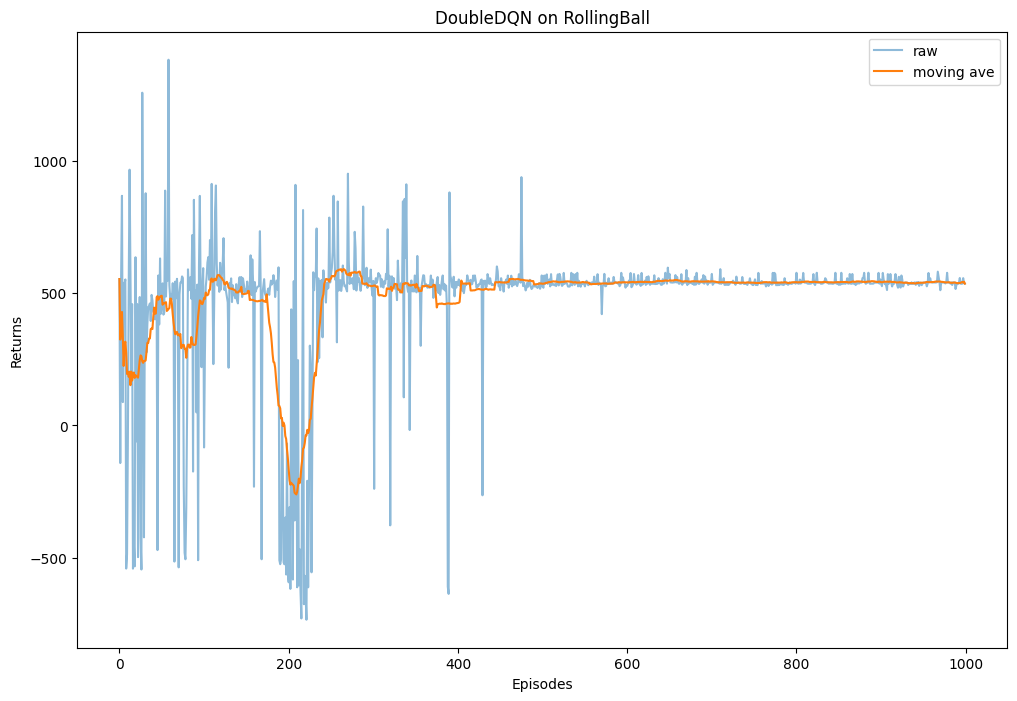

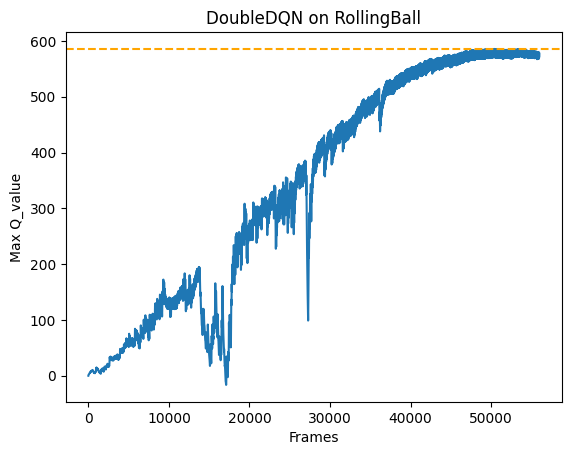

In [ ]:
if __name__ == "__main__":
    def moving_average(a, window_size):
        ''' 生成序列 a 的滑动平均序列 '''
        # 计算滑动平均，平滑序列（如回合回报），便于绘图时观察趋势
        # 参数：a（输入序列，如回报列表），window_size（窗口大小，后续设为 29）
        cumulative_sum = np.cumsum(np.insert(a, 0, 0))
        # 计算累积和，插入 0 便于差分计算窗口平均值
        middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
        # 中间部分：通过累积和差分计算窗口平均值
        r = np.arange(1, window_size-1, 2)
        # 生成奇数序列 [1, 3, 5, ...]，用于处理开头和结尾的小窗口
        begin = np.cumsum(a[:window_size-1])[::2] / r
        # 开头部分：计算前 window_size-1 个元素的小窗口平均值
        end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
        # 结尾部分：计算最后 window_size-1 个元素的反向小窗口平均值，翻转对齐
        return np.concatenate((begin, middle, end))
        # 拼接开头、中间、结尾，返回等长滑动平均序列

    def set_seed(env, seed=50):
        ''' 设置随机种子 '''
        # 设置随机种子，确保环境和算法行为一致，实验可重复
        env.action_space.seed(seed)
        # 为动作空间设置种子，确保动作采样一致
        env.reset(seed=seed)
        # 重置环境，应用种子，确保初始状态一致
        random.seed(seed)
        # 设置 Python random 模块种子，用于随机动作选择
        np.random.seed(seed)
        # 设置 NumPy 随机种子，用于数组操作和采样
        torch.manual_seed(seed)
        # 设置 PyTorch 种子，确保神经网络初始化和训练一致

    state_dim = 4                               # 环境观测维度
    # 状态维度为 4，对应 RollingBall 环境的观测 [x_position, y_position, x_velocity, y_velocity]
    action_dim = 1                              # 环境动作维度
    action_bins = 10                            # 动作离散 bins 数量
    action_range = action_bins * action_bins    # 环境动作空间大小
    hidden_dim = 32                             # 神经网络隐藏层大小
    # 学习率不建议太大，很难收敛
    lr = 0.001                                   # 学习率
    num_episodes = 1000                         # 总训练回合数
    gamma = 0.99                                # 折扣因子
    epsilon_start = 0.2                       # 初始探索率
    epsilon_end = 0.01                        # 最终探索率
    tau = 0.001                        # 目标网络更新参数
    buffer_size = 10000                         # 回放缓冲区容量
    minimal_size = 5000                         # 训练前最小缓冲区大小
    batch_size = 128                            # 批量大小
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # 优先使用 GPU（CUDA），否则使用 CPU，加速神经网络计算

    # 构建环境
    env = RollingBall(width=5, height=5, show_epi=True)
    # 创建 5x5 的 RollingBall 环境，显示小球轨迹
    # 参考 GridWorld.py：
    # - 初始位置：(1, 1)（0.2 * 5）
    # - 目标位置：(4, 4)（0.8 * 5）
    # - 奖励：每步 -2.0，撞墙 -10.0，目标 +300.0
    # - 动作空间：Box([-0.1, 0.1], shape=(2,))，x 和 y 方向的力
    # - 观测空间：Box([0, 0, -5, -5], [5, 5, 5, 5])，[x, y, vx, vy]
    env = FlattenActionSpaceWrapper(DiscreteActionWrapper(env, bins=10))
    # 包装动作空间：
    # 1. DiscreteActionWrapper（参考 Hashposotion.py）：
    #    - 将连续动作离散化为 MultiDiscrete([10, 10])
    #    - 每个维度 10 个 bins，映射到 [-1, 1]，步长 0.2
    # 2. FlattenActionSpaceWrapper：
    #    - 展平为 Discrete(100)，动作索引 0-99
    env = TimeLimit(env, 100)
    # 限制每回合最大 100 步，超限返回 truncated=True
    check_env(env.unwrapped)
    # 检查原始 RollingBall 环境是否符合 Gym 规范
    set_seed(env, seed=42)
    # 设置环境随机种子，确保一致性

    # 构建代理和回放缓冲区
    replay_buffer = ReplayBuffer(buffer_size)
    # 创建回放缓冲区，容量 10000，存储经验 (state, action, reward, next_state, done)
    agent = DoubleDQN(state_dim, hidden_dim, action_dim, action_range, lr, gamma, epsilon_start, tau, device)
    # 创建 DoubleDQN 代理（假设 DoubleDQN 类已定义）
    # 配置：4 维状态输入，100 个动作输出，32 单元隐藏层，学习率 0.001，折扣因子 0.99
    # 功能：epsilon-greedy 动作选择，Q 网络更新，目标网络定期同步

    # 随机动作填充回放缓冲区
    state, _ = env.reset()
    # 重置环境，获取初始状态
    while replay_buffer.size() <= minimal_size:
        action = env.action_space.sample()
        # 随机选择动作（0-99）
        next_state, reward, terminated, truncated, _ = env.step(action)
        # 执行动作，获取下一状态、奖励、终止标志等
        replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
        # 存储经验，done 表示回合是否结束
        state = next_state
        # 更新状态
        if terminated or truncated:
            env.render()
            # 回合结束时渲染，显示小球轨迹
            state, _ = env.reset()
            # 重置环境
        #print(replay_buffer.size())
        # （注释掉）可打印缓冲区大小，监控填充进度

    # 开始训练
    return_list = []
    # 存储每回合总回报
    max_q_value_list = []
    # 存储平滑的最大 Q 值
    max_q_value = 0
    # 用于平滑 Q 值的初始值
    for i in range(20):
        # 分 20 次迭代，每迭代 50 回合，共 1000 回合
        with tqdm(total=int(num_episodes / 20), desc='Iteration %d' % i) as pbar:
            # 使用 tqdm 显示进度条
            for i_episode in range(int(num_episodes / 20)):
                # 每迭代 50 回合
                episode_return = 0
                # 初始化回合回报
                state, _ = env.reset()
                # 重置环境
                while True:
                    # 计算并平滑最大 Q 值
                    max_q_value = agent.max_q_value_of_given_state(state) * 0.005 + max_q_value * 0.995
                    # 使用指数平滑，权重 0.005（新值）和 0.995（旧值）
                    max_q_value_list.append(max_q_value)
                    # 记录 Q 值

                    # 选择并执行动作
                    action = agent.take_action(state)
                    # 使用 epsilon-greedy 策略选择动作
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    # 执行动作，获取结果

                    # 更新回放缓冲区
                    replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
                    # 存储新经验

                    # 训练 Q 网络
                    assert replay_buffer.size() > minimal_size
                    # 确保缓冲区足够大
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    # 采样 128 条经验
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    # 组织批量数据
                    agent.update(transition_dict)
                    # 更新 Q 网络，计算 Q 学习损失并优化

                    state = next_state
                    # 更新状态
                    episode_return += reward
                    # 累加回报

                    if terminated or truncated:
                        env.render()
                        # 回合结束时渲染
                        if terminated:
                            print(f"Episode {num_episodes / 20 * i + i_episode + 1}: Goal reached!")   
                        break
                    #env.render()
                    # （注释掉）可每步渲染，但会减慢训练

                return_list.append(episode_return)
                # 记录回合回报
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                    # 每 10 回合更新进度条，显示回合数和最近 10 次平均回报
                pbar.update(1)
                # 更新进度条

        #env.render()
        # （注释掉）迭代结束时可渲染
        agent.epsilon += (epsilon_end - epsilon_start) / 10
        # 调整 epsilon，注意：应为衰减，可能需改为 agent.epsilon = epsilon_start + (epsilon_end - epsilon_start) * i / 19
    env.close()
    # 显示训练结果
    mv_return_list = moving_average(return_list, 29)
    # 计算 29 步滑动平均回报
    episodes_list = list(range(len(return_list)))
    # 生成回合索引
    plt.figure(figsize=(12,8))
    # 创建 12x8 英寸画布
    plt.plot(episodes_list, return_list, label='raw', alpha=0.5)
    # 绘制原始回报，半透明
    plt.plot(episodes_list, mv_return_list, label='moving ave')
    # 绘制平滑回报
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题，包含代理名称（如 DQN）
    plt.legend()
    # 显示图例
    plt.savefig(f'./result/{agent._get_name()}.png')
    # 保存回报曲线
    plt.show()
    # 显示图像
    # 显示最大 Q 值
    frames_list = list(range(len(max_q_value_list)))
    # 生成帧索引
    plt.plot(frames_list, max_q_value_list)
    # 绘制平滑 Q 值曲线
    plt.axhline(max(max_q_value_list), c='orange', ls='--')
    # 标记最大 Q 值
    plt.xlabel('Frames')
    plt.ylabel('Max Q_value')
    plt.title(f'{agent._get_name()} on RollingBall')
    # 设置标题
    plt.savefig(f'./result/{agent._get_name()}_MaxQ.png')
    # 保存 Q 值曲线
    plt.show()
    # 显示图像